In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_selection import RFECV
from sklearn.utils import shuffle
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")


In [84]:
train = pd.read_csv("Train_Data.csv")
test_df = pd.read_csv("Test_Data.csv")
train['Dataset'] = 'Train'
test_df['Dataset'] = 'Test'
test_df["age_group"] = np.nan
full_data = pd.concat([train, test_df], ignore_index=True)

sns.set(style="whitegrid")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1966 entries, 0 to 1965
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       1954 non-null   float64
 1   RIAGENDR   1948 non-null   float64
 2   PAQ605     1953 non-null   float64
 3   BMXBMI     1948 non-null   float64
 4   LBXGLU     1953 non-null   float64
 5   DIQ010     1948 non-null   float64
 6   LBXGLT     1955 non-null   float64
 7   LBXIN      1957 non-null   float64
 8   age_group  1952 non-null   object 
 9   Dataset    1966 non-null   object 
dtypes: float64(8), object(2)
memory usage: 153.7+ KB


# <span style="color:orange;">#EDA analysis</span>


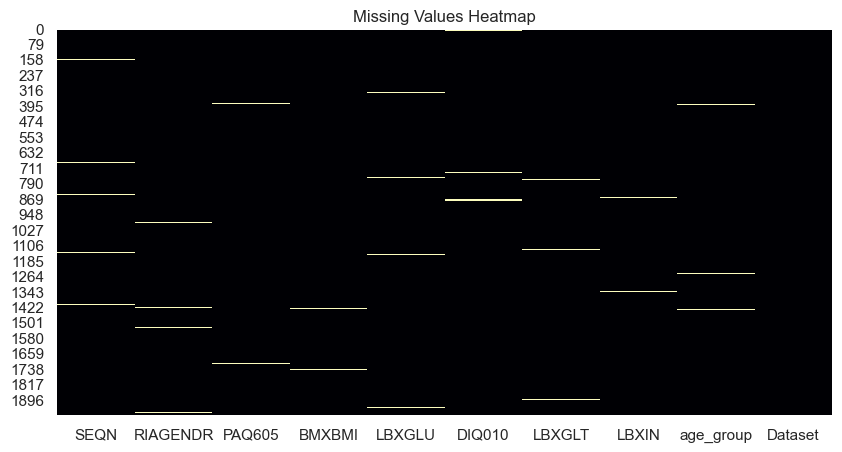

In [85]:
# 1. Missing values heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(train.isnull(), cbar=False, cmap="magma")
plt.title("Missing Values Heatmap")
plt.show()
#Most data is present (mostly black).
#Missing values are sparse and scattered, affecting a few samples per feature.
#Some features with occasional missing values:
#PAQ605, BMXBMI, LBXGLU, LBXGLT, LBXIN, DIQ010
#SEQN (ID) and age_group seem to have very few or no missing values.###

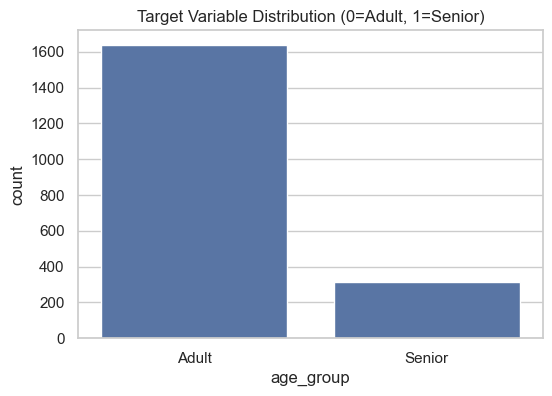

In [86]:
# 2. Target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='age_group', data=train)
plt.title("Target Variable Distribution (0=Adult, 1=Senior)")
plt.show()

In [87]:
# 3. Categorical Feature Distributions (low cardinality)
categorical_cols = train.select_dtypes(include='object').columns.tolist()
categorical_cols += train.select_dtypes(include='category').columns.tolist()
categorical_cols += [col for col in train.columns if train[col].dtype in ['int64', 'float64'] and train[col].nunique() < 10 and col != 'age_group']


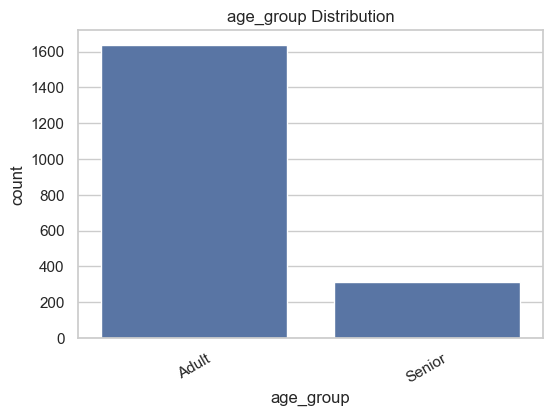

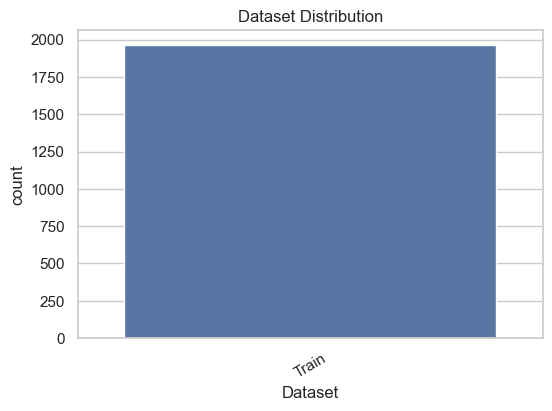

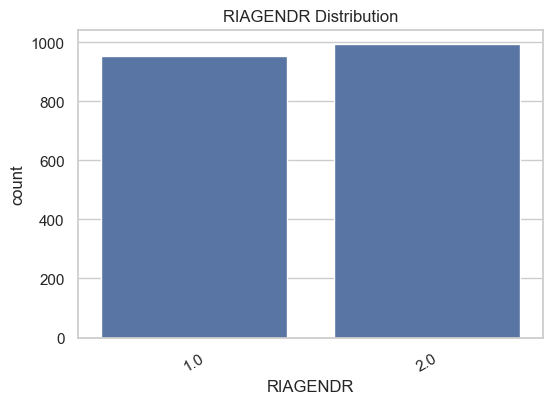

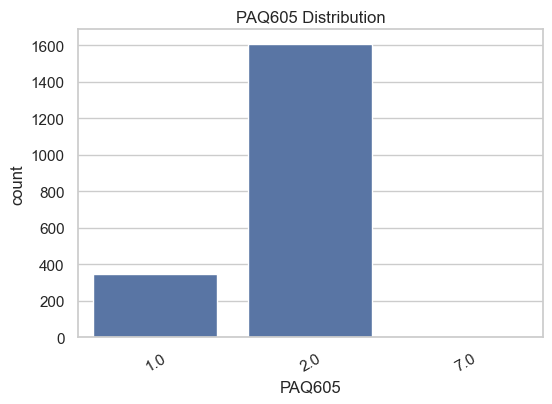

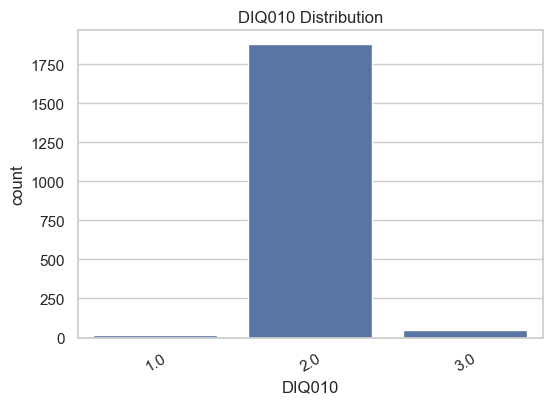

In [88]:
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=train)
    plt.title(f"{col} Distribution")
    plt.xticks(rotation=30)
    plt.show()
  

The dataset is imbalanced with respect to age.
The dataset has an almost equal number of males and females.
A majority (value 2) of respondents do not participate in moderate activity.
A smaller portion does (value 1).
A few invalid or non-informative responses (value 7) may need to be handled (e.g., dropped or imputed).
A very large majority report not having diabetes (2.0).
Very few have diabetes (1.0) or are borderline (3.0).
This is a highly imbalanced feature and may not help in models unless balanced carefully.

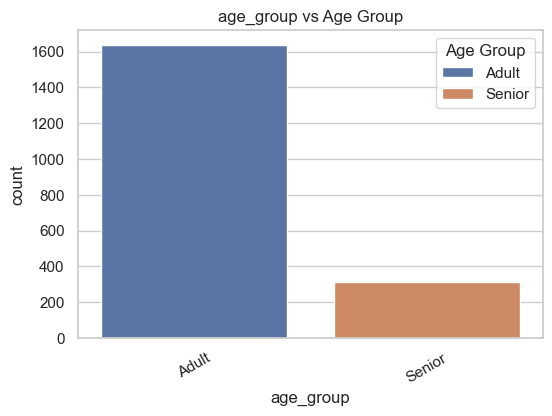

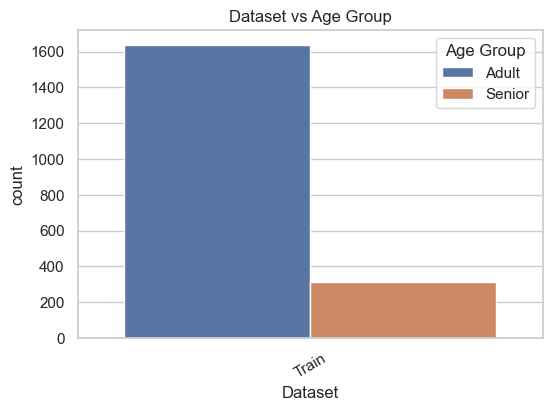

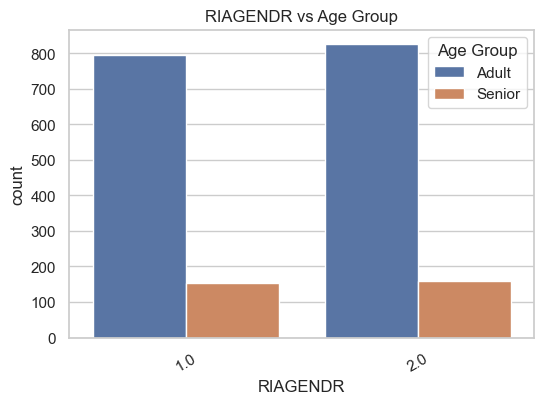

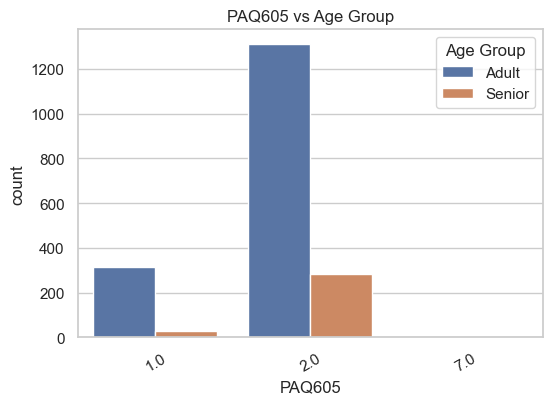

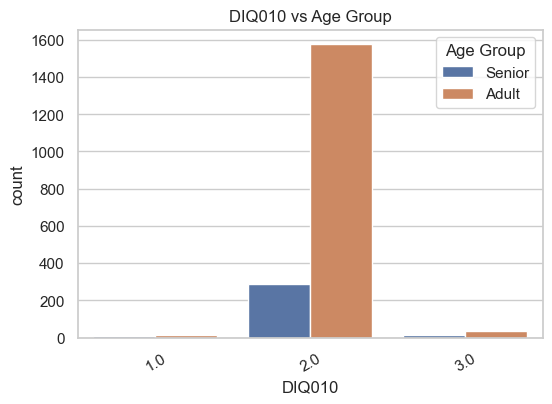

In [89]:
# 4. Categorical Feature vs Target Analysis
for col in categorical_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, hue='age_group', data=train)
    plt.title(f"{col} vs Age Group")
    plt.xticks(rotation=30)
    plt.legend(title='Age Group')
    plt.show()

Insight  
Class imbalance: Adults ≫ Seniors  
Gender distribution is balanced across age groups 
PAQ605 (Physical Activity) vs Age Group:
Adults are more physically active.
Seniors show significantly lower activity levels.
DIQ010 (Diabetes) vs Age Group:
Seniors have much higher diabetes prevalence.
Adults are mostly non-diabetic.

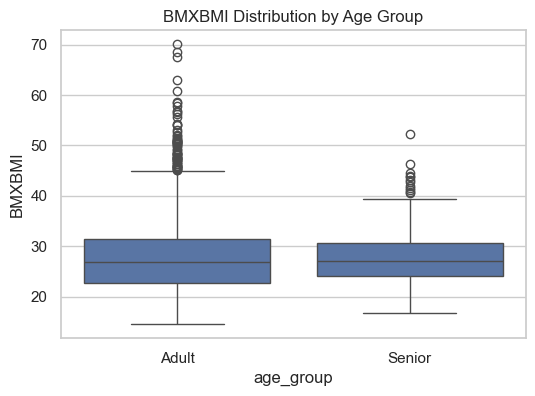

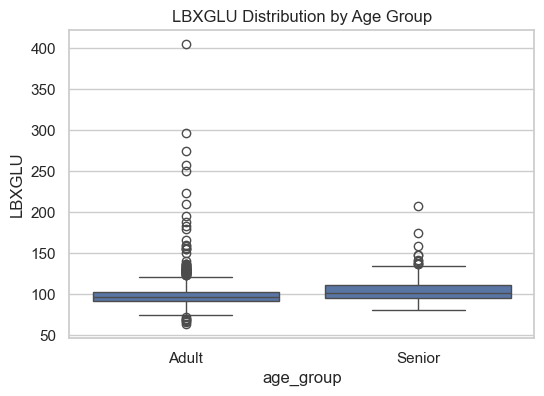

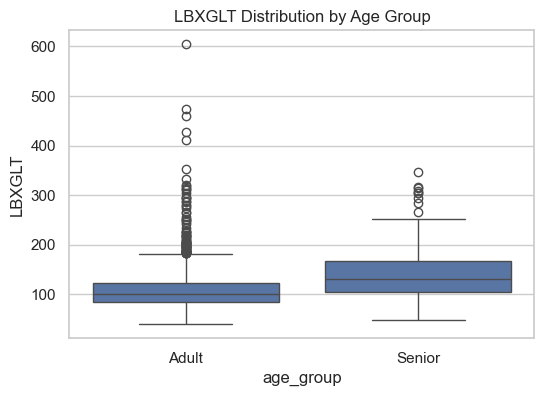

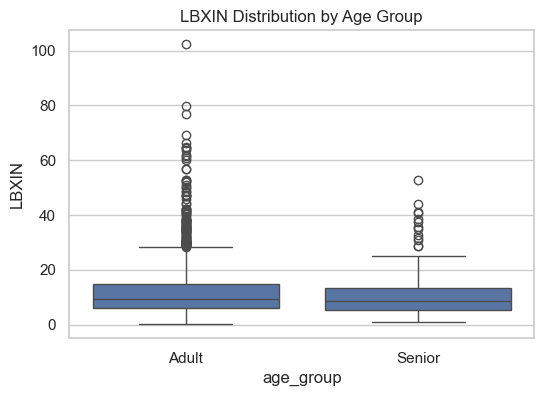

In [90]:
# 5. Boxplots of Numeric Features vs Target
num_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x='age_group', y=col, data=train)
    plt.title(f"{col} Distribution by Age Group")
    plt.show()

BMXBMI (Body Mass Index) by Age Group
Adults show a wider BMI range, with more variability.
Seniors tend to have slightly higher median BMI, suggesting weight retention or metabolic changes with age.
Implication: BMI remains a relevant health marker across ages, but its distribution shifts slightly in seniors.

LBXGLU (Fasting Glucose) by Age Group
Seniors have higher glucose levels on average, aligning with increased diabetes/metabolic risk.
Adults cluster around lower, healthier glucose ranges.
Implication: Age-related insulin resistance likely drives higher glucose in seniors.

LBXGLT (Glucose Tolerance) by Age Group
Seniors show elevated post-meal glucose (LBXGLT), indicating impaired glucose tolerance.
Adults maintain tighter control, with most values in normal ranges.
Implication: Declining metabolic efficiency with age is evident.

LBXIN (Insulin Levels) by Age Group
Seniors have higher median insulin, suggesting insulin resistance.
Adults exhibit lower, more stable insulin levels.
Implication: Compensatory hyperinsulinemia (overproduction of insulin) may occur in seniors due to reduced sensitivity

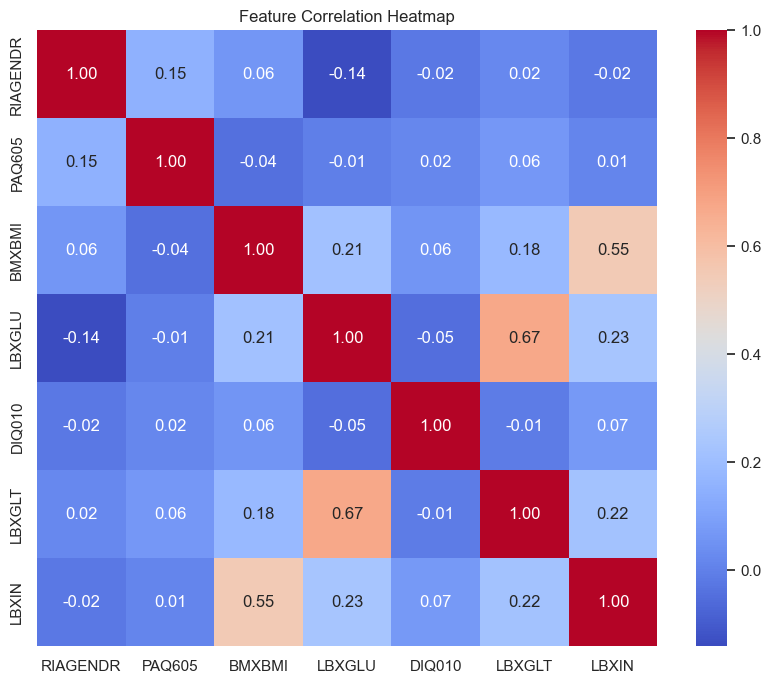

In [91]:
# 6. Correlation heatmap
plt.figure(figsize=(10, 8))
numeric_cols = train.select_dtypes(include=['int64', 'float64']).drop(columns=['SEQN'], errors='ignore')
corr = numeric_cols.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Strong Positive Correlations:

LBXGLU and LBXGLT show a strong positive correlation (0.67), suggesting these are likely related glucose measurements or metabolic markers
BMXBMI and LBXIN have a moderate positive correlation (0.55), indicating body mass index is associated with insulin levels, which makes biological sense

Weak Overall Correlations:

Most feature pairs show very weak correlations (close to 0), indicating the features are largely independent of each other
This suggests the dataset contains diverse, non-redundant information across different health domains

RIAGENDR (likely gender) shows very weak correlations with all other variables, suggesting gender doesn't strongly predict these particular health metrics in this dataset
PAQ605 (possibly a physical activity questionnaire item) is also weakly correlated with other measures
DIO010 appears relatively independent from other variables

 # <span style="color:orange;">Imputation</span>

In [92]:
# Target Preprocessing 
full_data.loc[full_data['age_group'] == 'Adult', 'age_group'] = 0
full_data.loc[full_data['age_group'] == 'Senior', 'age_group'] = 1


In [93]:
numeric_cols = ['BMXBMI', 'LBXGLU', 'LBXGLT', 'LBXIN']
knn_imputer = KNNImputer(n_neighbors=3)
full_data[numeric_cols] = knn_imputer.fit_transform(full_data[numeric_cols])

mode_imputer = SimpleImputer(strategy='most_frequent')
full_data[['PAQ605', 'DIQ010', 'RIAGENDR']] = mode_imputer.fit_transform(full_data[['PAQ605', 'DIQ010', 'RIAGENDR']])


 # <span style="color:orange;">Feature Engineering with justification</span>

In [94]:
def bmi_cat(bmi):
    if bmi < 18.5: return "Underweight"
    elif bmi < 25: return "Normal"
    elif bmi < 30: return "Overweight"
    else: return "Obese"

full_data['BMI_cat'] = full_data['BMXBMI'].apply(bmi_cat)
full_data['Physically_Active'] = full_data['PAQ605'].apply(lambda x: 1 if x == 1 else 0)
full_data['Activity_Valid'] = full_data['PAQ605'].apply(lambda x: 1 if x in [1, 2] else 0)
full_data['Has_Diabetes'] = full_data['DIQ010'].apply(lambda x: 1 if x == 1 else 0)
full_data['Diabetes_Cat'] = full_data['DIQ010'].apply(lambda x: 2 if x == 1 else (1 if x == 3 else 0))
full_data['GIR'] = full_data['LBXGLU'] / (full_data['LBXIN'] + 1e-5)
full_data['GLU_GLT_interact'] = full_data['LBXGLU'] * full_data['LBXGLT']
full_data['BMI_INSULIN_index'] = full_data['BMXBMI'] * full_data['LBXIN']


 # <span style="color:orange;">Zscore</span>

In [95]:
z_scaler = StandardScaler()
full_data[['BMI_z', 'GLU_z', 'GLT_z', 'IN_z']] = z_scaler.fit_transform(full_data[numeric_cols])

# <span style="color:orange;">#risk score </span>

In [96]:
full_data['Risk_Score'] = (
    (full_data['BMI_cat'] == 'Obese').astype(int) +
    full_data['Has_Diabetes'] +
    (full_data['Physically_Active'] == 0).astype(int)
)

# <span style="color:orange;">various models </span>

In [97]:
# Polynomial Feature
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
poly_feats = poly.fit_transform(full_data[['GLU_z', 'GLT_z', 'IN_z']])
poly_df = pd.DataFrame(poly_feats[:, -3:], columns=['GLU_GLUT', 'GLU_IN', 'GLT_IN'])
full_data = pd.concat([full_data.reset_index(drop=True), poly_df], axis=1)

In [98]:
# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
full_data['Cluster_Label'] = kmeans.fit_predict(full_data[numeric_cols])


In [99]:
# One-hot encode
full_data = pd.get_dummies(full_data, columns=['BMI_cat'], drop_first=True)

In [100]:
print(full_data.columns)

Index(['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT',
       'LBXIN', 'age_group', 'Dataset', 'Physically_Active', 'Activity_Valid',
       'Has_Diabetes', 'Diabetes_Cat', 'GIR', 'GLU_GLT_interact',
       'BMI_INSULIN_index', 'BMI_z', 'GLU_z', 'GLT_z', 'IN_z', 'Risk_Score',
       'GLU_GLUT', 'GLU_IN', 'GLT_IN', 'Cluster_Label', 'BMI_cat_Obese',
       'BMI_cat_Overweight', 'BMI_cat_Underweight'],
      dtype='object')


In [101]:
#  Train-Test Split
train_fe = full_data[full_data['Dataset'] == 'Train'].drop(columns=['Dataset', 'SEQN'])
test_fe = full_data[full_data['Dataset'] == 'Test'].drop(columns=['Dataset', 'SEQN', 'age_group'])
train_fe = train_fe[train_fe['age_group'].notna()]
X = train_fe.drop(columns=['age_group'])
y = train_fe['age_group'].astype(int)

In [102]:
#SMOTE balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


In [103]:
#Feature Selection
selector = RFECV(RandomForestClassifier(), step=1, cv=3, scoring='f1_macro')
selector.fit(X_resampled, y_resampled)
X_selected = selector.transform(X_resampled)
test_selected = selector.transform(test_fe)

In [104]:
# Model Ensemble
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42)),
    ('xgb', XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, use_label_encoder=False, eval_metric='logloss', random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, class_weight='balanced')),
    ('lgbm', LGBMClassifier(n_estimators=200, max_depth=7, class_weight='balanced', random_state=42))
]

stack = StackingClassifier(estimators=models, final_estimator=LogisticRegression(), cv=cv)
stack.fit(X_selected, y_resampled)

[LightGBM] [Info] Number of positive: 1638, number of negative: 1638
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3985
[LightGBM] [Info] Number of data points in the train set: 3276, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=10,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping...
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=200, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('lr',
                                LogisticRegression(class_weight='balanced',
                                                   max_iter=1000)),
                               ('lgbm',
                                LGBMClassifier(class_weight='balanced',
                                               max_depth=7, n_estimators=200,
                                               random_state=42))],
                   final_estimator=LogisticRegression())

In [105]:
# Evaluation
y_pred_train = stack.predict(X_selected)
print("Train Accuracy:", accuracy_score(y_resampled, y_pred_train))
print("Train F1 Score:", f1_score(y_resampled, y_pred_train))


Train Accuracy: 0.9954212454212454
Train F1 Score: 0.9954114408075864


In [106]:
# Final Submission
test_preds = stack.predict(test_selected)
pd.DataFrame({"age_group": test_preds.astype(int)}).to_csv("submission.csv", index=False)
print("✅ submission.csv saved")

✅ submission.csv saved
